# 2252621

# Home Exercise on Named Entity Recognition

Implement a **Recurrent Neural Network model** (**[Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991)**) to extract named entities from text. Entity labels are encoded using the **BIO notation**, where each entity label is assigned a **B** (Beginning) or **I** (Inside) tag. The **B-** tag indicates the beginning of an entity, while the **I-** tag marks words inside the same entity.

These tags help identify multi-word entities. For example, in the phrase **"World War II"**, the labels would be: **(B-eve, I-eve, I-eve)**. Words that do not belong to any entity are labeled as **O** (Outside).

- **Data**: [Annotated GMB Corpus](https://www.kaggle.com/datasets/shoumikgoswami/annotated-gmb-corpus?select=GMB_dataset.txt) *(the last 10% of rows serve as the test set).*

**Note**: Submit only a **single Jupyter Notebook file** that can handle all tasks, including data downloading, preprocessing, model training, and model evaluation. *(Submissions that do not follow the guidelines will receive a score of 0.)*

## Grading Criteria

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

- **Top 25%** → **10 points**
- **25% - 50%** → **9.0 points**
- **50% - 75%** → **8.0 points**
- **75% - 100%** → **7.0 points**


# Install Packages

In [44]:
%pip install deep_translator
%pip install pandas numpy gdown nltk matplotlib deep-translator
%pip install seqeval
%pip install tensorflow tensorflow-addons keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# %pip install git+https://www.github.com/keras-team/keras-contrib.git

# Import Libraries

In [45]:
import pandas as pd
import numpy as np
import re
import os
import gdown
import string
import random
import nltk
import tensorflow as tf
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

from keras.models import Model, Sequential, load_model
from keras.layers import Input
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from keras_contrib.layers import CRF

import tensorflow_addons as tfa
from tensorflow_addons.text import crf_log_likelihood
from tensorflow_addons.layers import CRF

import keras as k

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ensure NLTK data is available
nltk.download('wordnet')


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Download data of the kaggle dataset from the pre-downloaded gdrive link

In [46]:
# https://drive.google.com/drive/folders/1GbEc7KGjuiByArwjt3CS69Lrk-ttJ4Ly?usp=sharing

# URL of the shared folder
folder_url = "https://drive.google.com/drive/folders/1GbEc7KGjuiByArwjt3CS69Lrk-ttJ4Ly?usp=sharing"

# Output directory where the folder will be saved
output_dir = "./NLP_Data_GDrive"

# Download the folder
gdown.download_folder(folder_url, output=output_dir, quiet=False, use_cookies=False)


Retrieving folder contents


Processing file 125vSHeQajcbRTMJiq4Hc5WPH-GcCxkVr annotated-gmb-corpus.zip
Processing file 1gTWviZN3RcBUzm--_ife7qCUuTb1H8lr GMB_dataset.txt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=125vSHeQajcbRTMJiq4Hc5WPH-GcCxkVr
To: /content/NLP_Data_GDrive/annotated-gmb-corpus.zip
100%|██████████| 473k/473k [00:00<00:00, 99.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gTWviZN3RcBUzm--_ife7qCUuTb1H8lr
To: /content/NLP_Data_GDrive/GMB_dataset.txt
100%|██████████| 1.60M/1.60M [00:00<00:00, 102MB/s]
Download completed


['./NLP_Data_GDrive/annotated-gmb-corpus.zip',
 './NLP_Data_GDrive/GMB_dataset.txt']

In [85]:
# Load dataset (Ensure file path is correct)
file_path = os.path.join(output_dir, "GMB_dataset.txt")  # Adjust file path if needed

# Check if files exist
if not os.path.exists(file_path):
    raise FileNotFoundError("File not found. Check the download process and file paths.")

# df = pd.read_csv(file_path, delimiter="\t", names=["Sentence#", "Word", "POS", "Tag"], skiprows=1)
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence#", "Word", "POS", "Tag"], skiprows=1, encoding="latin1")

# Fill missing Sentence# values
df["Sentence#"] = df["Sentence#"].fillna(method="ffill")
data = df

<ipython-input-85-74466524684d>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence#"] = df["Sentence#"].fillna(method="ffill")


In [86]:
data.tail(10)

,Sentence#,Word,POS,Tag
66151,2999.0,reporters,NNS,O
66152,2999.0,a,DT,O
66153,2999.0,trial,NN,O
66154,2999.0,date,NN,O
66155,2999.0,could,MD,O
66156,2999.0,be,VB,O
66157,2999.0,announced,VBN,O
66158,2999.0,within,IN,B-tim
66159,2999.0,days,NNS,O
66160,2999.0,.,.,O


In [84]:
# data.head(30)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66161 entries, 0 to 66160
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentence#  66161 non-null  float64
 1   Word       66161 non-null  object 
 2   POS        66161 non-null  object 
 3   Tag        66161 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.5+ MB


# Data Processing and Augmentation

In [113]:
def get_synonyms(word):
    """ Get synonyms for a word using WordNet. """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)
    return list(synonyms)

def introduce_typos(word, prob=0.2):
    """ Introduce typos by swapping adjacent characters. """
    if random.random() > prob or len(word) < 3:
        return word
    idx = random.randint(0, len(word) - 2)
    return word[:idx] + word[idx + 1] + word[idx] + word[idx + 2:]

def split_data(data):
    """ Split dataset into 90% training and 10% test based on Sentence#. """
    # Note that here we split them only and later we do data augmentation on the train_data and keep the test_data unchanged
    unique_sentences = sorted(data['Sentence#'].unique())
    split_index = int(len(unique_sentences) * 0.9)
    train_sentences = unique_sentences[:split_index]
    test_sentences = unique_sentences[split_index:]

    train_data = data[data['Sentence#'].isin(train_sentences)].copy()
    test_data = data[data['Sentence#'].isin(test_sentences)].copy()

    return train_data, test_data

def augment_sentence_group(df_group, prob=0.3):
    """ Apply augmentation to each sentence group (identified by Sentence#). """
    augmented_sentences = []
    sentence_id = df_group['Sentence#'].iloc[0]  # Keep the same sentence number for now

    for _, row in df_group.iterrows():
        word = row['Word']

        # Synonym Replacement (30% chance)
        if random.random() < prob:
            synonyms = get_synonyms(word)
            if synonyms:
                word = random.choice(synonyms)

        # Typos (10% chance)
        if random.random() < 0.1:
            word = introduce_typos(word)

        augmented_sentences.append([sentence_id, word, row['POS'], row['Tag']])

    # Shuffle Words (5% chance)
    if random.random() < 0.05:
        random.shuffle(augmented_sentences)

    return pd.DataFrame(augmented_sentences, columns=df_group.columns)

def augment_data(df, num_augmented_copies=2):
    """
    Apply augmentation to the dataset.
    - `num_augmented_copies`: Number of augmented copies to generate for each sentence.
    """
    augmented_data = []
    max_sentence_id = df['Sentence#'].max()  # Start new sentence IDs from the last one

    for _ in range(num_augmented_copies):
        augmented_df = df.groupby("Sentence#").apply(lambda group: augment_sentence_group(group)).reset_index(drop=True)
        # Assign new sentence numbers to augmented sentences
        augmented_df['Sentence#'] = augmented_df['Sentence#'].apply(lambda x: x + max_sentence_id)
        max_sentence_id += df['Sentence#'].nunique()  # Increment to avoid duplication

        augmented_data.append(augmented_df)

    # Combine original with augmented data
    final_df = pd.concat([df] + augmented_data, ignore_index=True)
    return final_df

def duplicate_ner_rows_with_synonyms(df, num_duplicates=3):
    # Filter NER rows
    ner_rows = df[df['Tag'] != 'O']

    augmented_rows = []

    for _ in range(num_duplicates):
        for _, row in ner_rows.iterrows():
            word = row['Word']
            pos = row['POS']
            tag = row['Tag']
            sentence_id = row['Sentence#']

            # Try to find a synonym for the word
            synonyms = get_synonyms(word)
            new_word = random.choice(synonyms) if synonyms else word  # use synonym if available

            # Create a new row with possibly replaced word
            augmented_rows.append({
                'Sentence#': sentence_id,
                'Word': new_word,
                'POS': pos,
                'Tag': tag
            })

    # Convert list to DataFrame
    augmented_df = pd.DataFrame(augmented_rows)

    # Combine original with new duplicated rows
    final_df = pd.concat([df, augmented_df], ignore_index=True)

    return final_df


def process_data(data, num_augmented_copies=2, num_ner_duplicates=3):
    """
    Complete data processing pipeline:
    1. Split into train & test (last 10% of sentences reserved for testing).
    2. Apply augmentation to the training set only.
    3. Duplicate NER-tagged rows for balance at the very end.
    """
    # Step 1: Split into training and test set
    train_data, test_data = split_data(data)

    # Step 2: Apply augmentation only to training data and keep the test data unchanged
    train_data_augmented = augment_data(train_data, num_augmented_copies=num_augmented_copies)

    # Step 3: Duplicate Named Entity rows in training data and keep the test data unchanged
    train_data_final = duplicate_ner_rows_with_synonyms(train_data_augmented, num_duplicates=num_ner_duplicates)

    # Finally, return the preprocessed train data and unchanged-from-original test data
    return train_data_final, test_data

# Example Usage
# Assuming `data` is your original DataFrame
train_data, test_data = process_data(data, num_augmented_copies=2, num_ner_duplicates=2)

print(train_data.info())
print(test_data.info())

<ipython-input-113-642e6dcff116>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  augmented_df = df.groupby("Sentence#").apply(lambda group: augment_sentence_group(group)).reset_index(drop=True)
<ipython-input-113-642e6dcff116>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  augmented_df = df.groupby("Sentence#").apply(lambda group: augment_sentence_group(group)).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232914 entries, 0 to 232913
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Sentence#  232914 non-null  float64
 1   Word       232914 non-null  object 
 2   POS        232914 non-null  object 
 3   Tag        232914 non-null  object 
dtypes: float64(1), object(3)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 6409 entries, 59752 to 66160
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentence#  6409 non-null   float64
 1   Word       6409 non-null   object 
 2   POS        6409 non-null   object 
 3   Tag        6409 non-null   object 
dtypes: float64(1), object(3)
memory usage: 250.4+ KB
None


In [114]:
train_data.tail(20)

,Sentence#,Word,POS,Tag
232894,8094.0,ANC,NNP,B-org
232895,8095.0,2012,CD,B-tim
232896,8096.0,ANC,NNP,B-org
232897,8096.0,Confederate_States_of_America,NNP,B-geo
232898,8096.0,Africa,NNP,I-geo
232899,8096.0,goal,NN,B-tim
232900,8096.0,of,IN,I-tim
232901,8096.0,apartheid,NN,I-tim
232902,8096.0,Indiana,IN,I-tim
232903,8096.0,1994,CD,I-tim


In [115]:
test_data.tail(20)

,Sentence#,Word,POS,Tag
66141,2998.0,for,IN,O
66142,2998.0,an,DT,O
66143,2998.0,attempted,JJ,O
66144,2998.0,assassination,NN,O
66145,2998.0,of,IN,O
66146,2998.0,Saddam,NNP,B-per
66147,2998.0,.,.,O
66148,2999.0,The,DT,O
66149,2999.0,judge,NN,O
66150,2999.0,told,VBD,O


In [14]:
# df_concat = pd.concat([data, data_other], ignore_index=True)
# print(df_concat.head())
# print(df_concat.info())

In [15]:
# df_concat = df_concat[df_concat['Sentence#'].notnull()]
# df_concat = df_concat.drop_duplicates()

In [116]:
# Count occurrences of each tag in the dataset
tag_counts = train_data["Tag"].value_counts()

# Print tag counts
print(tag_counts)

Tag
O        152427
B-geo     16380
B-gpe     10233
B-org     10224
I-per      9963
B-tim      9423
B-per      8667
I-org      7470
I-geo      3420
I-tim      2718
B-art       477
B-eve       369
I-art       306
I-eve       297
I-gpe       288
B-nat       171
I-nat        81
Name: count, dtype: int64


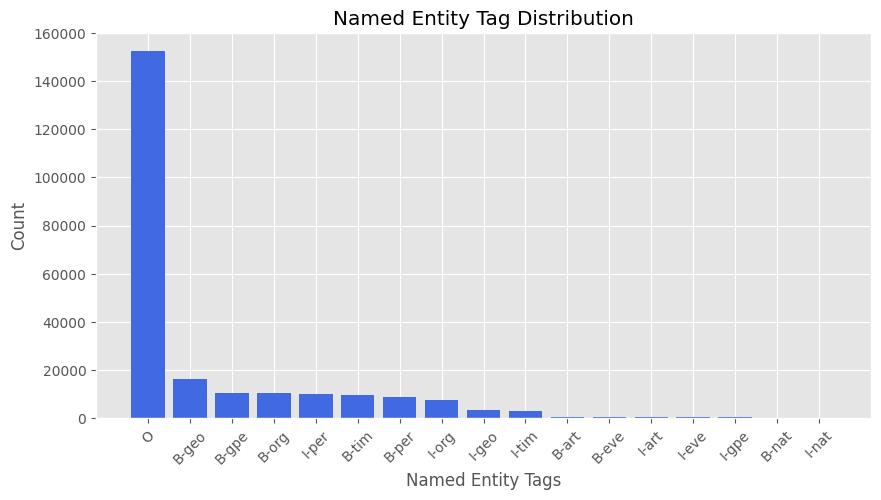

In [117]:
# Sort tags by frequency for better visualization
tag_counts_sorted = tag_counts.sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(tag_counts_sorted.index, tag_counts_sorted.values, color='royalblue')
plt.xlabel("Named Entity Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.title("Named Entity Tag Distribution")
plt.show()


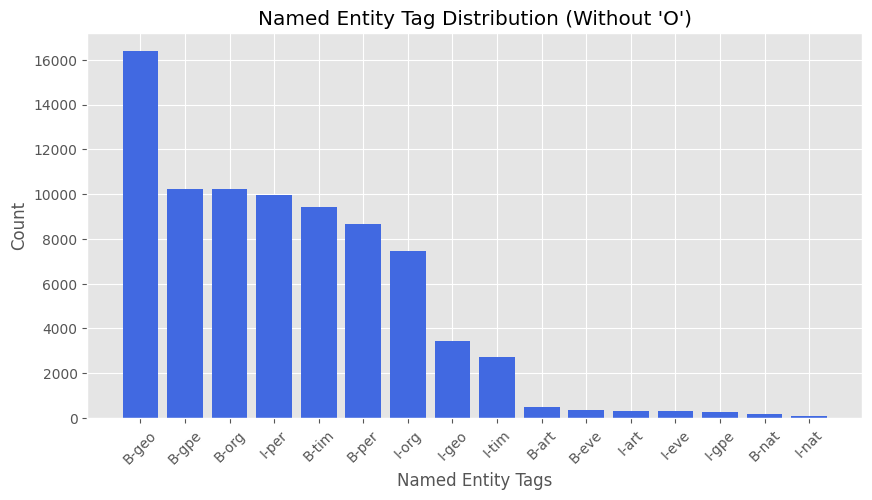

In [118]:
tag_counts_filtered = tag_counts.drop("O")

tag_counts_sorted = tag_counts_filtered.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(tag_counts_sorted.index, tag_counts_sorted.values, color='royalblue')
plt.xlabel("Named Entity Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.title("Named Entity Tag Distribution (Without 'O')")
plt.show()


In [119]:
data_all = pd.concat([train_data, test_data], ignore_index=True)
data_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239323 entries, 0 to 239322
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Sentence#  239323 non-null  float64
 1   Word       239323 non-null  object 
 2   POS        239323 non-null  object 
 3   Tag        239323 non-null  object 
dtypes: float64(1), object(3)
memory usage: 7.3+ MB


In [120]:
words = list(set(data_all["Word"].values))
words.append("ENDPAD")
n_words = len(words);
n_words


17454

In [121]:
tags = list(set(data_all["Tag"].values))
n_tags = len(tags); n_tags

17

In [122]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [123]:
getter = SentenceGetter(data_all)
getter_train = SentenceGetter(train_data)
getter_test = SentenceGetter(test_data)


<ipython-input-122-c9a46b593c0f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence#").apply(agg_func)
<ipython-input-122-c9a46b593c0f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence#").apply(agg_func)
<ipython-input-122-c9a46b593c0f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This b

In [124]:
sent = getter_test.get_next()
print(sent)

None


In [125]:
sentences = getter.sentences
sentences_train = getter_train.sentences
sentences_test = getter_test.sentences

# sentences_train[10]

# Prepare the data for training

In [126]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [127]:
word2idx["Obama"]

16188

In [128]:
tag2idx["B-geo"]

16

In [129]:
# pad the sequence
X_train = [[word2idx[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=word2idx["ENDPAD"])

X_test = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx["ENDPAD"])

In [130]:
# # pad the target
# y_train = [[tag2idx[w[2]] for w in s] for s in sentences_train]
# y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
# y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

# y_test = [[tag2idx[w[2]] for w in s] for s in sentences_test]
# y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])
# y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

In [131]:
# Check shape after converting tags to indices
y_train = [[tag2idx[w[2]] for w in s] for s in sentences_train]
y_test = [[tag2idx[w[2]] for w in s] for s in sentences_test]

# print("Shape of y_train before padding:", y_train)
# print("Shape of y_test before padding:", y_test)

# Check shape after padding
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

print("Shape of y_train after padding:", y_train.shape)
print("Shape of y_test after padding:", y_test.shape)

# Check shape after one-hot encoding
y_train = np.array([to_categorical(i, num_classes=n_tags) for i in y_train])
y_test = np.array([to_categorical(i, num_classes=n_tags) for i in y_test])

print("Shape of y_train after one-hot encoding:", y_train.shape)
print("Shape of y_test after one-hot encoding:", y_test.shape)

Shape of y_train after padding: (8097, 75)
Shape of y_test after padding: (300, 75)
Shape of y_train after one-hot encoding: (8097, 75, 17)
Shape of y_test after one-hot encoding: (300, 75, 17)


In [132]:
# X = [[word2idx[w[0]] for w in s] for s in sentences]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [133]:
# from keras.utils import to_categorical
# y = [to_categorical(i, num_classes=n_tags) for i in y]
# from sklearn.model_selection import train_test_split
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Defining BiLSTM-CRF Model: Basic

## Setup the BiLSTM-CRF 1: Basic

This model gets the performance on the test set like this:

```
Accuracy-score: 97.9%
Precision-score: 61.6%
Recall-score: 57.8%
F1-score: 59.6%
              precision    recall  f1-score   support

         eve       0.00      0.00      0.00         4
         geo       0.73      0.56      0.64       250
         gpe       0.85      0.85      0.85        93
         nat       0.00      0.00      0.00         1
         org       0.32      0.47      0.38       101
         per       0.53      0.41      0.46       144
         tim       0.71      0.73      0.72       113

   micro avg       0.62      0.58      0.60       706
   macro avg       0.45      0.43      0.43       706
weighted avg       0.64      0.58      0.60       706
```


In [134]:
class BiLSTMCRF(tf.keras.Model):
    def __init__(self, max_len, n_words, n_tags):
        super(BiLSTMCRF, self).__init__()
        self.embedding = Embedding(input_dim=n_words+1, output_dim=200, input_length=max_len)
        self.dropout = Dropout(0.5)
        self.bilstm = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))
        self.dense = TimeDistributed(Dense(n_tags))
        # self.dense = TimeDistributed(Dense(n_tags, activation="relu"))
        self.crf = CRF(n_tags)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.dropout(x, training=training)
        x = self.bilstm(x)
        logits = self.dense(x)
        self.decode_tags, self.potentials, self.sequence_lengths, self.transition_params = self.crf(logits)
        return self.potentials  # return logits for loss calculation

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            potentials = self(x, training=True)
            log_likelihood, _ = tfa.text.crf_log_likelihood(
                potentials,
                tag_indices=tf.argmax(y, axis=-1),
                sequence_lengths=self.sequence_lengths,
                transition_params=self.transition_params
            )
            loss = -tf.reduce_mean(log_likelihood)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        y_pred = tf.argmax(potentials, axis=-1)
        y_true = tf.argmax(y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

        return {"loss": loss, "crf_accuracy": acc}

    def test_step(self, data):
        x, y = data
        potentials = self(x, training=False)
        log_likelihood, _ = tfa.text.crf_log_likelihood(
            potentials,
            tag_indices=tf.argmax(y, axis=-1),
            sequence_lengths=self.sequence_lengths,
            transition_params=self.transition_params
        )
        loss = -tf.reduce_mean(log_likelihood)

        y_pred = tf.argmax(potentials, axis=-1)
        y_true = tf.argmax(y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

        return {"loss": loss, "crf_accuracy": acc}


In [135]:
model = BiLSTMCRF(max_len=max_len, n_words=n_words, n_tags=n_tags)
model.compile(optimizer='adam')

# Build it with dummy input shape so we can see summary
model.build(input_shape=(None, max_len))
model.summary()


Model: "bi_lstmcrf_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    multiple                  3491000   
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 bidirectional_12 (Bidirect  multiple                  336896    
 ional)                                                          
                                                                 
 time_distributed_12 (TimeD  multiple                  4369      
 istributed)                                                     
                                                                 
 crf_12 (CRF)                multiple                  629       
                                                                 
Total params: 3832894 (14.62 MB)
Trainable params: 383

## Train and Test with 1st Model

In [137]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
114/114 [==============================] - 105s 914ms/step - loss: 37.6517 - crf_accuracy: 0.8720 - val_loss: 41.8606 - val_crf_accuracy: 0.8308
Epoch 2/5
114/114 [==============================] - 92s 808ms/step - loss: 23.2681 - crf_accuracy: 0.9053 - val_loss: 26.6206 - val_crf_accuracy: 0.8962
Epoch 3/5
114/114 [==============================] - 98s 859ms/step - loss: 14.0224 - crf_accuracy: 0.9483 - val_loss: 15.1572 - val_crf_accuracy: 0.9460
Epoch 4/5
114/114 [==============================] - 92s 805ms/step - loss: 8.9997 - crf_accuracy: 0.9652 - val_loss: 10.4944 - val_crf_accuracy: 0.9603
Epoch 5/5
114/114 [==============================] - 93s 817ms/step - loss: 6.2983 - crf_accuracy: 0.9740 - val_loss: 8.4401 - val_crf_accuracy: 0.9663


In [138]:
hist = pd.DataFrame(history.history)
# model.save("crf_model1.h5")
model.save("crf_model1.keras")
loaded_model = tf.keras.models.load_model("crf_model1.keras", custom_objects={"BiLSTMCRF": BiLSTMCRF})

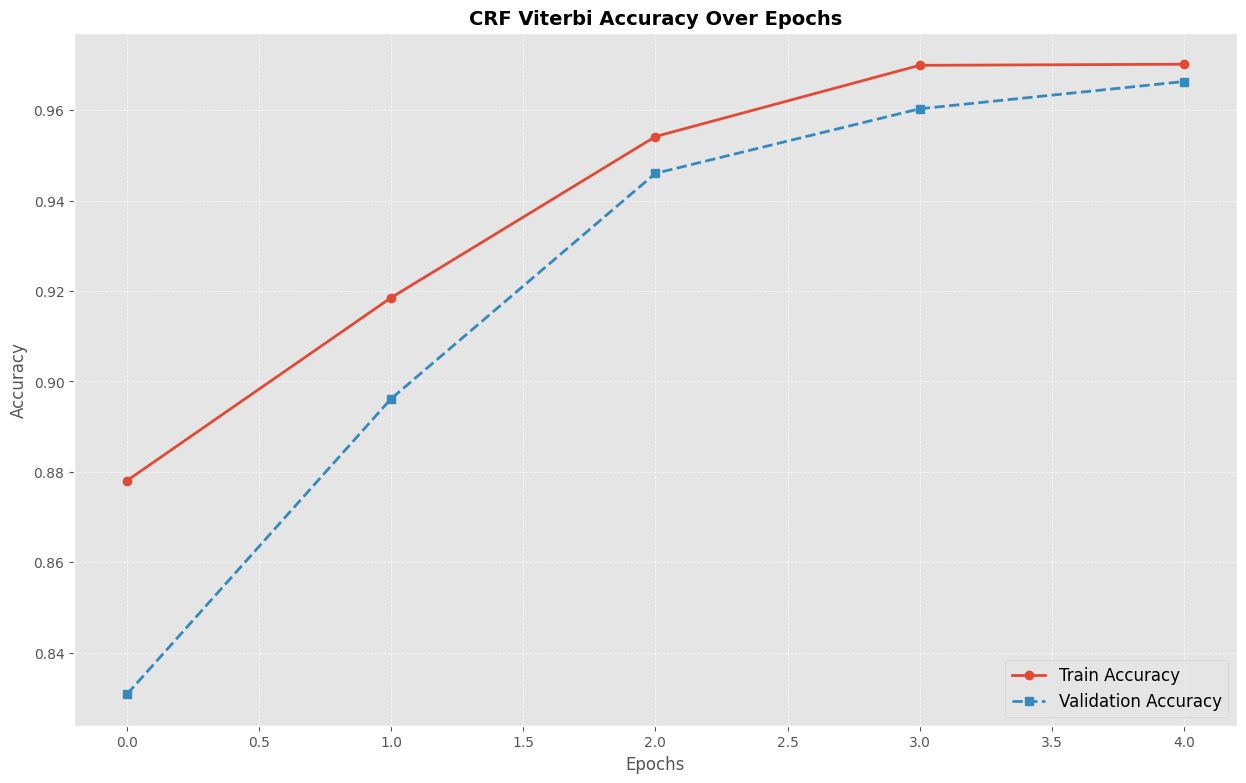

In [139]:
# Use "ggplot" style for better aesthetics
plt.style.use("ggplot")

# Create the figure
plt.figure(figsize=(15, 9))  # Adjust size for better visualization

# Plot training and validation accuracy
plt.plot(hist["crf_accuracy"], label="Train Accuracy", marker='o', linestyle='-', linewidth=2)
plt.plot(hist["val_crf_accuracy"], label="Validation Accuracy", marker='s', linestyle='--', linewidth=2)

# Add title and labels
plt.title("CRF Viterbi Accuracy Over Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Add legend
plt.legend(loc="lower right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Show the plot
plt.show()


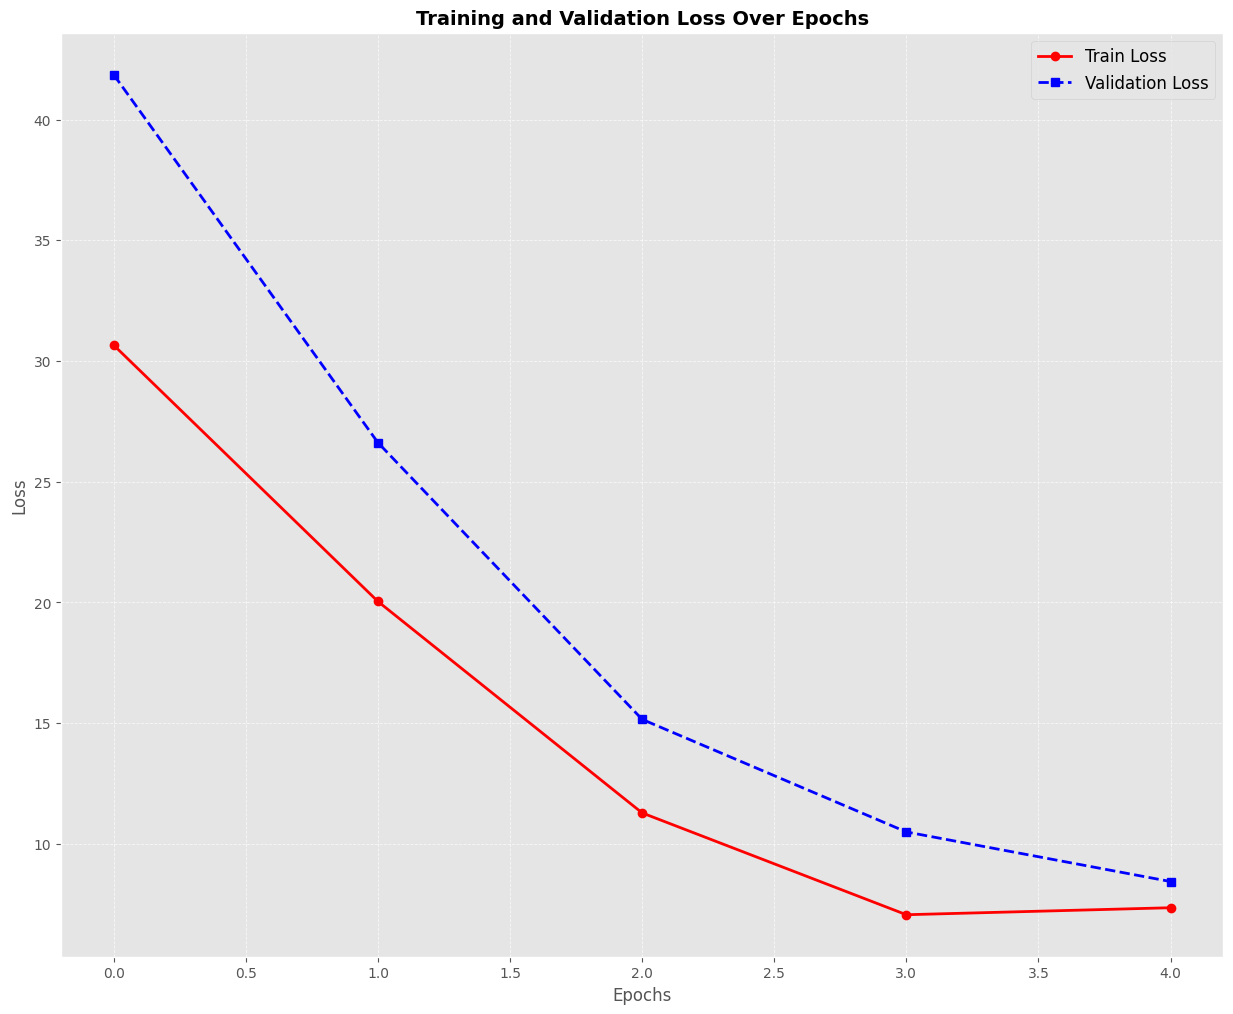

In [140]:
# Use "ggplot" style for better aesthetics
plt.style.use("ggplot")

# Create the figure
plt.figure(figsize=(15, 12))  # Adjust size for better visualization

# Plot training and validation loss
plt.plot(hist["loss"], label="Train Loss", marker='o', linestyle='-', linewidth=2, color='red')
plt.plot(hist["val_loss"], label="Validation Loss", marker='s', linestyle='--', linewidth=2, color='blue')

# Add title and labels
plt.title("Training and Validation Loss Over Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Add legend
plt.legend(loc="upper right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Show the plot
plt.show()


In [141]:
logits = model.predict(X_test)

10/10 [==============================] - 1s 55ms/step


In [142]:
viterbi_sequences = []
for logit in logits:
    viterbi_seq, _ = tfa.text.viterbi_decode(logit, model.transition_params.numpy())
    viterbi_sequences.append(viterbi_seq)

In [143]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(preds):
    out = []
    for pred in preds:
        out.append([idx2tag[i] for i in pred])
    return out

def true2label(y_true):
    out = []
    for true_seq in y_true:
        out.append([idx2tag[np.argmax(tag_vec)] for tag_vec in true_seq])
    return out

pred_labels = pred2label(viterbi_sequences)
true_labels = true2label(y_test)

print("Accuracy-score: {:.1%}".format(accuracy_score(true_labels, pred_labels)))
print("Precision-score: {:.1%}".format(precision_score(true_labels, pred_labels)))
print("Recall-score: {:.1%}".format(recall_score(true_labels, pred_labels)))
print("F1-score: {:.1%}".format(f1_score(true_labels, pred_labels)))
print(classification_report(true_labels, pred_labels))

Accuracy-score: 97.9%
Precision-score: 61.6%
Recall-score: 57.8%
F1-score: 59.6%
              precision    recall  f1-score   support

         eve       0.00      0.00      0.00         4
         geo       0.73      0.56      0.64       250
         gpe       0.85      0.85      0.85        93
         nat       0.00      0.00      0.00         1
         org       0.32      0.47      0.38       101
         per       0.53      0.41      0.46       144
         tim       0.71      0.73      0.72       113

   micro avg       0.62      0.58      0.60       706
   macro avg       0.45      0.43      0.43       706
weighted avg       0.64      0.58      0.60       706



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [154]:
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

1/1 [==============================] - 0s 85ms/step
Word           ||True ||Pred
Both           : O     O
sides          : O     O
hope           : O     O
to             : O     O
gain           : O     O
an             : O     O
edge           : O     O
in             : O     O
talks          : O     O
on             : O     O
a              : O     O
new            : O     O
government     : O     O
after          : O     O
the            : O     O
inconclusive   : O     O
September      : B-tim B-tim
18             : I-tim I-tim
balloting      : O     I-tim
left           : O     O
Ms.            : B-per B-per
Merkel         : B-geo B-org
's             : O     I-org
Christian      : B-geo B-tim
Democrats      : I-geo I-org
just           : O     O
three          : O     I-org
seats          : O     O
ahead          : O     O
of             : O     O
the            : O     O
Chancellor     : B-per B-per
's             : O     O
Social         : O     B-org
Democrats      : O     I-

In [147]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

In [152]:
# test_sentence="On 18/04/2004, Barack Obama said that he loved his country which is Vietnam very much. You know, Apple is such an amazing tech company."
test_sentence = "On January 1st, 2023, Elon Musk announced that Tesla would open a new factory in Jakarta, Indonesia, partnering with Samsung and MIT."
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=0, maxlen=max_len)

In [153]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

1/1 [==============================] - 0s 43ms/step
Word           ||Prediction
On             : O    
January        : B-tim
1st            : I-tim
,              : O    
2023           : O    
,              : O    
Elon           : O    
Musk           : O    
announced      : O    
that           : O    
Tesla          : O    
would          : O    
open           : O    
a              : O    
new            : O    
factory        : O    
in             : O    
Jakarta        : B-geo
,              : O    
Indonesia      : B-geo
,              : O    
partnering     : O    
with           : O    
Samsung        : O    
and            : O    
MIT            : O    
.              : O    


# Defining BiLSTM-CRF Model: more advanced

This model gets the performance on the test set like this:

```
Accuracy-score: 98.1%
Precision-score: 69.8%
Recall-score: 61.3%
F1-score: 65.3%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00         0
         eve       0.00      0.00      0.00         4
         geo       0.80      0.64      0.71       250
         gpe       0.86      0.81      0.83        93
         nat       0.00      0.00      0.00         1
         org       0.44      0.47      0.45       101
         per       0.63      0.47      0.54       144
         tim       0.75      0.75      0.75       113

   micro avg       0.70      0.61      0.65       706
   macro avg       0.44      0.39      0.41       706
weighted avg       0.71      0.61      0.66       706
```


## Setup the BiLSTM-CRF 2: little bit better



In [175]:
class BiLSTMCRF_Advanced(tf.keras.Model):
    def __init__(self, max_len, n_words, n_tags,
                 embedding_dim=200,
                 lstm_units=128,
                 dropout_rate=0.4,
                 recurrent_dropout=0.25,
                 l2_reg=0.01):
        super(BiLSTMCRF_Advanced, self).__init__()

        self.embedding = Embedding(input_dim=n_words + 1, output_dim=embedding_dim, input_length=max_len)
        self.dropout = Dropout(dropout_rate)

        self.bilstm = Bidirectional(LSTM(
            units=lstm_units,
            return_sequences=True,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg)
        ))

        # this good with
        # Accuracy-score: 98.1%
        # Precision-score: 67.3%
        # Recall-score: 61.6%
        # F1-score: 64.3%
        # self.dense = TimeDistributed(Dense(n_tags, activation="relu"))

        # now test for no relu - this seems to be better with no relu as activation
        self.dense = TimeDistributed(Dense(n_tags))
        self.crf = CRF(n_tags)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.dropout(x, training=training)
        x = self.bilstm(x)
        logits = self.dense(x)
        self.decode_tags, self.potentials, self.sequence_lengths, self.transition_params = self.crf(logits)
        return self.potentials

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            potentials = self(x, training=True)
            log_likelihood, _ = tfa.text.crf_log_likelihood(
                potentials,
                tag_indices=tf.argmax(y, axis=-1),
                sequence_lengths=self.sequence_lengths,
                transition_params=self.transition_params
            )
            loss = -tf.reduce_mean(log_likelihood)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        y_pred = tf.argmax(potentials, axis=-1)
        y_true = tf.argmax(y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

        return {"loss": loss, "crf_accuracy": acc}

    def test_step(self, data):
        x, y = data
        potentials = self(x, training=False)
        log_likelihood, _ = tfa.text.crf_log_likelihood(
            potentials,
            tag_indices=tf.argmax(y, axis=-1),
            sequence_lengths=self.sequence_lengths,
            transition_params=self.transition_params
        )
        loss = -tf.reduce_mean(log_likelihood)

        y_pred = tf.argmax(potentials, axis=-1)
        y_true = tf.argmax(y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

        return {"loss": loss, "crf_accuracy": acc}



In [176]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.0025, beta_1=0.9, beta_2=0.999, decay=1e-4, clipnorm=1.0
)

model = BiLSTMCRF_Advanced(max_len=max_len, n_words=n_words, n_tags=n_tags)
model.compile(optimizer=optimizer)
model.build(input_shape=(None, max_len))  # For model.summary()
model.summary()

Model: "bi_lstmcrf__advanced_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    multiple                  3491000   
                                                                 
 dropout_17 (Dropout)        multiple                  0         
                                                                 
 bidirectional_17 (Bidirect  multiple                  336896    
 ional)                                                          
                                                                 
 time_distributed_17 (TimeD  multiple                  4369      
 istributed)                                                     
                                                                 
 crf_17 (CRF)                multiple                  629       
                                                                 
Total params: 3832894 (14.62 MB)
Trainable p

## Train and Test with 2nd Model

In [177]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_crf_accuracy",  # from test_step
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [178]:
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.1,
    verbose=1,
    callbacks=[lr_scheduler]
)

Epoch 1/5
114/114 [==============================] - 99s 805ms/step - loss: 31.4326 - crf_accuracy: 0.8937 - val_loss: 18.5762 - val_crf_accuracy: 0.9286 - lr: 0.0025
Epoch 2/5
114/114 [==============================] - 89s 777ms/step - loss: 8.7672 - crf_accuracy: 0.9618 - val_loss: 8.2082 - val_crf_accuracy: 0.9657 - lr: 0.0025
Epoch 3/5
114/114 [==============================] - 90s 787ms/step - loss: 4.4375 - crf_accuracy: 0.9776 - val_loss: 5.8581 - val_crf_accuracy: 0.9759 - lr: 0.0025
Epoch 4/5
114/114 [==============================] - 90s 793ms/step - loss: 2.6718 - crf_accuracy: 0.9856 - val_loss: 4.9491 - val_crf_accuracy: 0.9787 - lr: 0.0025
Epoch 5/5
114/114 [==============================] - 89s 784ms/step - loss: 1.7682 - crf_accuracy: 0.9902 - val_loss: 4.9294 - val_crf_accuracy: 0.9806 - lr: 0.0025


In [179]:
hist = pd.DataFrame(history.history)
# model.save("crf_model1.h5")
model.save("crf_model2.keras")
loaded_model = tf.keras.models.load_model("crf_model2.keras", custom_objects={"BiLSTMCRF_Advanced": BiLSTMCRF_Advanced})

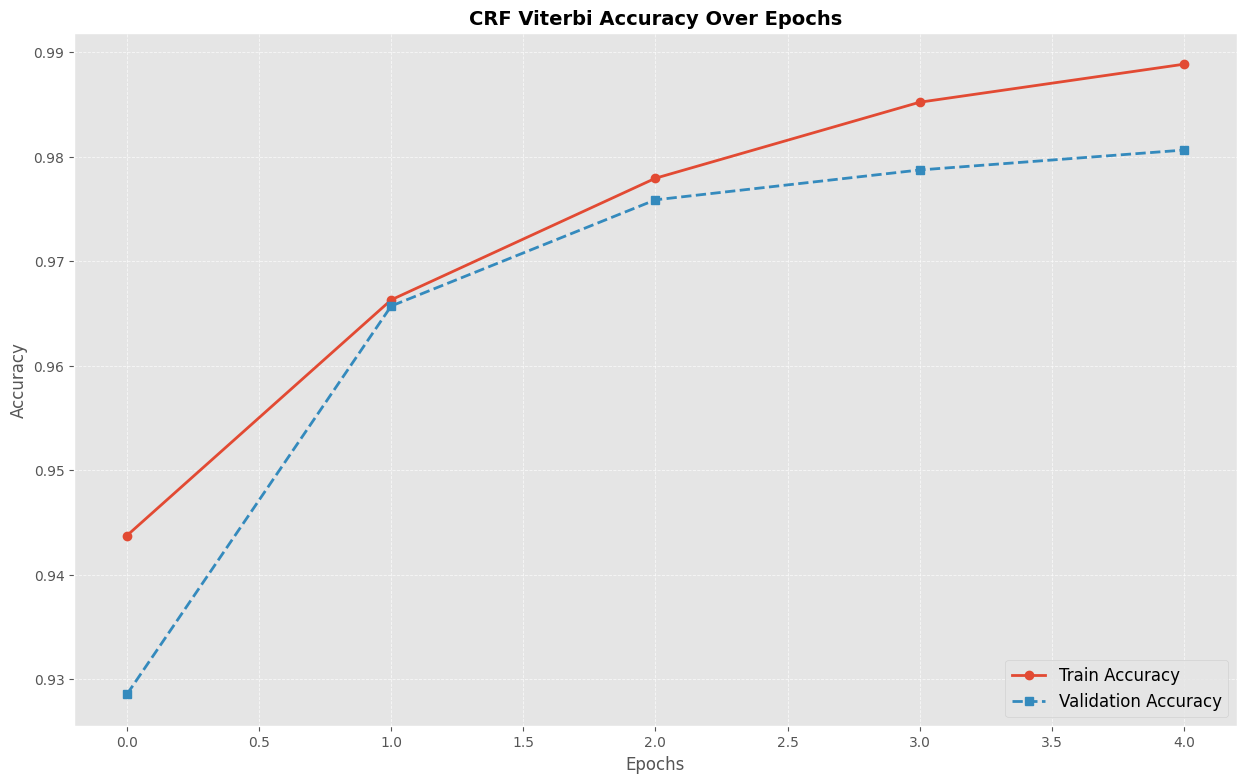

In [180]:
# Use "ggplot" style for better aesthetics
plt.style.use("ggplot")

# Create the figure
plt.figure(figsize=(15, 9))  # Adjust size for better visualization

# Plot training and validation accuracy
plt.plot(hist["crf_accuracy"], label="Train Accuracy", marker='o', linestyle='-', linewidth=2)
plt.plot(hist["val_crf_accuracy"], label="Validation Accuracy", marker='s', linestyle='--', linewidth=2)

# Add title and labels
plt.title("CRF Viterbi Accuracy Over Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Add legend
plt.legend(loc="lower right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Show the plot
plt.show()

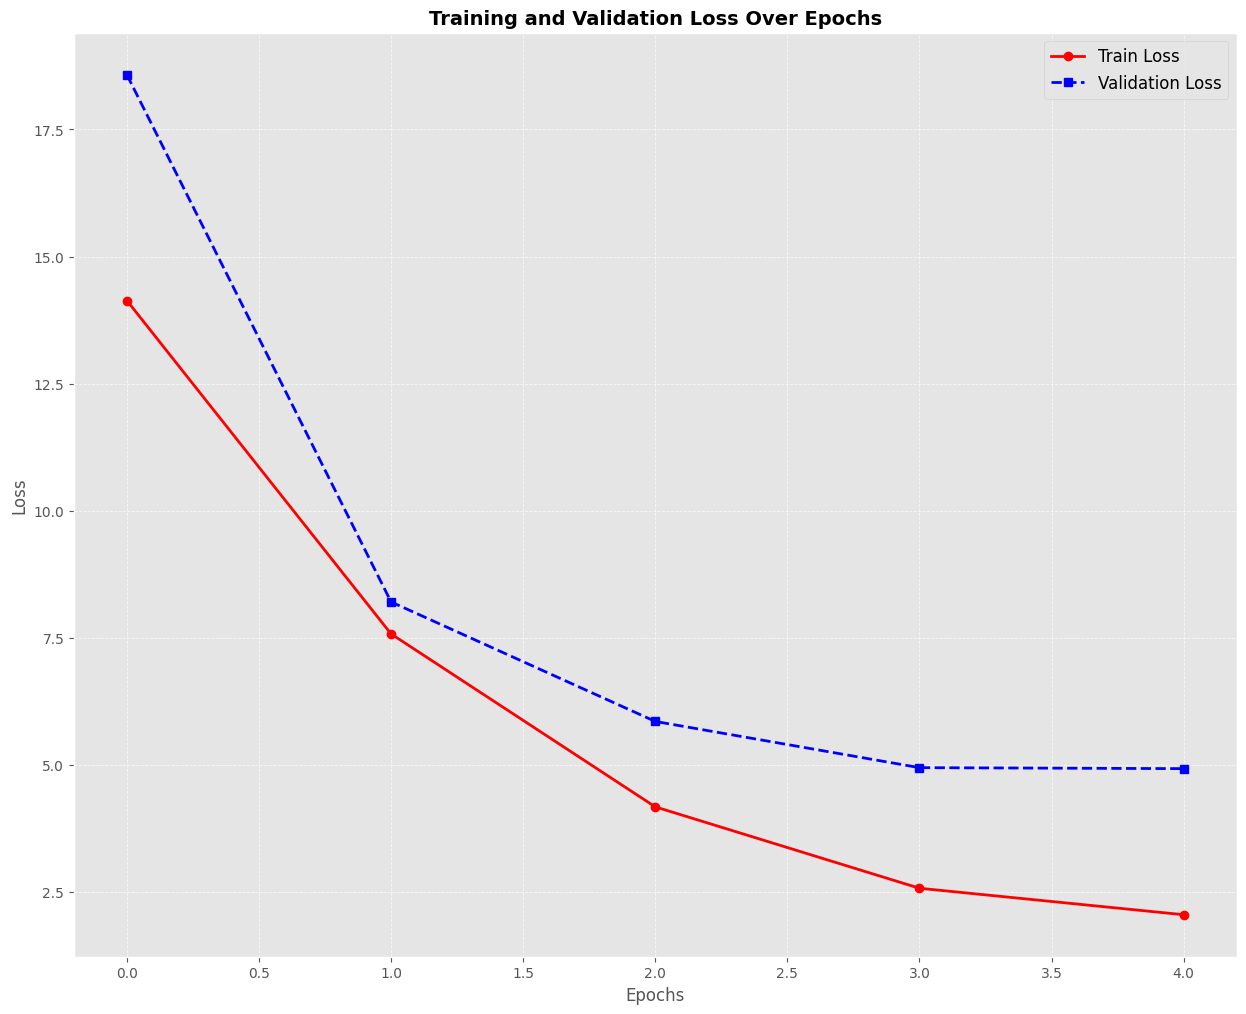

In [181]:
# Use "ggplot" style for better aesthetics
plt.style.use("ggplot")

# Create the figure
plt.figure(figsize=(15, 12))  # Adjust size for better visualization

# Plot training and validation loss
plt.plot(hist["loss"], label="Train Loss", marker='o', linestyle='-', linewidth=2, color='red')
plt.plot(hist["val_loss"], label="Validation Loss", marker='s', linestyle='--', linewidth=2, color='blue')

# Add title and labels
plt.title("Training and Validation Loss Over Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Add legend
plt.legend(loc="upper right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Show the plot
plt.show()

In [182]:
model = loaded_model
logits = model.predict(X_test)

10/10 [==============================] - 1s 57ms/step


In [183]:
viterbi_sequences = []
for logit in logits:
    viterbi_seq, _ = tfa.text.viterbi_decode(logit, model.transition_params.numpy())
    viterbi_sequences.append(viterbi_seq)

pred_labels = pred2label(viterbi_sequences)
true_labels = true2label(y_test)

print("Accuracy-score: {:.1%}".format(accuracy_score(true_labels, pred_labels)))
print("Precision-score: {:.1%}".format(precision_score(true_labels, pred_labels)))
print("Recall-score: {:.1%}".format(recall_score(true_labels, pred_labels)))
print("F1-score: {:.1%}".format(f1_score(true_labels, pred_labels)))
print(classification_report(true_labels, pred_labels))


Accuracy-score: 98.1%
Precision-score: 69.8%
Recall-score: 61.3%
F1-score: 65.3%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00         0
         eve       0.00      0.00      0.00         4
         geo       0.80      0.64      0.71       250
         gpe       0.86      0.81      0.83        93
         nat       0.00      0.00      0.00         1
         org       0.44      0.47      0.45       101
         per       0.63      0.47      0.54       144
         tim       0.75      0.75      0.75       113

   micro avg       0.70      0.61      0.65       706
   macro avg       0.44      0.39      0.41       706
weighted avg       0.71      0.61      0.66       706



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

1/1 [==============================] - 0s 73ms/step
Word           ||True ||Pred
German         : B-gpe B-gpe
Chancellor     : B-per B-per
Gerhard        : I-per I-per
Schroeder      : I-per I-per
and            : O     O
his            : O     O
challenger     : O     O
,              : O     O
Angela         : B-per B-per
Merkel         : I-per B-org
,              : O     O
are            : O     O
campaigning    : O     O
in             : O     O
the            : O     O
eastern        : O     O
city           : O     O
of             : O     O
Dresden        : B-geo O
ahead          : O     O
of             : O     O
Sunday         : B-tim B-tim
's             : O     O
vote           : O     O
for            : O     O
the            : O     O
only           : O     O
seat           : O     O
left           : O     O
undecided      : O     O
in             : O     O
this           : O     O
month          : O     O
's             : O     O
parliamentary  : O     O
elections      :

In [191]:
# test_sentence="On 18/04/2004, Barack Obama said that he loved his country which is Vietnam very much. You know, Apple is such an amazing tech company."
test_sentence = "On January 1st, 2023, Elon Musk announced that Tesla would open a new factory in Jakarta, Indonesia, partnering with Samsung and MIT."
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=0, maxlen=max_len)

p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

1/1 [==============================] - 0s 56ms/step
Word           ||Prediction
On             : O    
January        : B-tim
1st            : B-tim
,              : O    
2023           : O    
,              : O    
Elon           : O    
Musk           : O    
announced      : O    
that           : O    
Tesla          : O    
would          : O    
open           : O    
a              : O    
new            : O    
factory        : O    
in             : O    
Jakarta        : B-geo
,              : O    
Indonesia      : B-geo
,              : O    
partnering     : O    
with           : O    
Samsung        : O    
and            : O    
MIT            : O    
.              : O    
